# Metodi basati su Kernel
Confronto tra:
- Ridge Regression
- Kernel Ridge Regression
- Gaussian Processes

## Dataset
Creo un dataset per un task di regressione

In [5]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples = 1000, n_features = 3, noise = 0)

## Visualize embedding

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

def visualize_embedding(X_embedded, y, title):
    dim = X_embedded.shape[1]
    if dim not in [2, 3]:
        raise ValueError("Embedding dimension must be 2 or 3 for visualization.")

    plt.figure(figsize=(8, 6))
    if dim == 2:
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.7, edgecolor='k')
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
    else:  # 3D plot
        ax = plt.axes(projection='3d')
        sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2],
                        c=y, cmap='viridis', alpha=0.7, edgecolor='k')
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")

    plt.title(title)
    plt.tight_layout()
    plt.show()

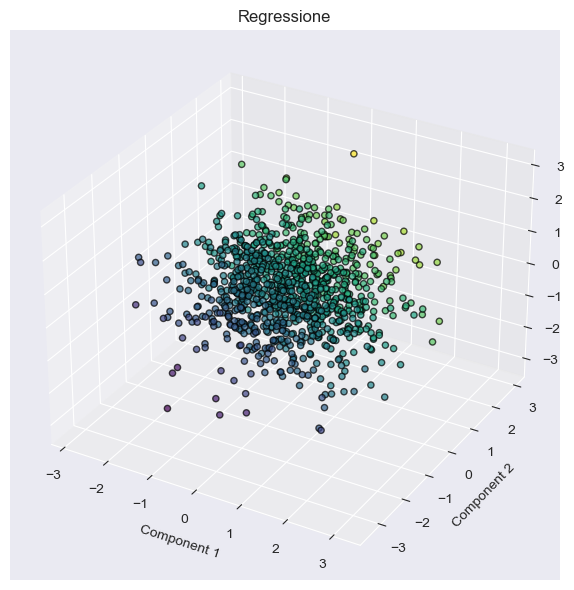

In [6]:
visualize_embedding(X, y, "Regressione")

# Nested Cross-Validation

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score, root_mean_squared_error, mean_absolute_error

def nested_cv(model, param_grid, X, y, outer_splits=5,
              inner_splits=5, scoring=['accuracy', 'roc_auc'],
              random_state=42, verbose=True):

    # Assicurati che `y` sia un array 1D
    if isinstance(y, pd.DataFrame):  # Se è un DataFrame Pandas
        y = y.values.ravel()
    elif isinstance(y, pd.Series):  # Se è una Serie Pandas
        y = y.values
    else:  # Se è un array Numpy
        y = np.ravel(y)

    # CROSS-VALIDATION ESTERNA
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    score_results = {metric: [] for metric in scoring}

    best_param_overall = None
    main_metric = scoring[0]

    # 1. INIZIALIZZAZIONE INTELLIGENTE
    # Se la metrica è un errore, partiamo da infinito per minimizzare.
    # Altrimenti, partiamo da -infinito per massimizzare.
    if main_metric in ['mae', 'rmse']:
        best_score = np.inf
    else:
        best_score = -np.inf

    # Logica di conversione
    main_metric_for_gridsearch = main_metric
    if main_metric == 'mae':
        main_metric_for_gridsearch = 'neg_mean_absolute_error'
    elif main_metric == 'rmse':
        # Nelle versioni recenti di sklearn, 'rmse' è un alias per 'neg_root_mean_squared_error',
        # ma essere espliciti è più sicuro.
        main_metric_for_gridsearch = 'neg_root_mean_squared_error'

    for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
        if verbose:
            print(f"\nPerforming Outer Fold {outer_fold}/{outer_splits}")

        # Usare il metodo .iloc per X, se è un DataFrame
        if isinstance(X, pd.DataFrame):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        else:  # Altrimenti usa indicizzazione standard
            X_train, X_test = X[train_idx], X[test_idx]

        y_train, y_test = y[train_idx], y[test_idx]

        # CROSS-VALIDATION INTERNA con GridSearchCV
        inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
        if verbose:
            print("Performing GridSearchCV...")

        # Usa la metrica convertita in GridSearchCV
        grid_search = GridSearchCV(model, param_grid, cv=inner_cv,
                                   n_jobs=-1, scoring=main_metric_for_gridsearch)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        if verbose:
            print(f" Best Params: {best_params}")

        # Test del modello ottimale sui dati di test dell'outer fold
        y_pred = best_model.predict(X_test)

        # Calcolo delle metriche
        if 'accuracy' in scoring:
            acc = accuracy_score(y_test, y_pred)
            score_results['accuracy'].append(acc)
            if main_metric == 'accuracy' and acc > best_score:
                best_score = acc
                best_param_overall = best_params
            if verbose:
                print(f" Accuracy: {acc:.4f}")

        if 'roc_auc' in scoring:
            try:
                y_score = best_model.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test, y_score)
                score_results['roc_auc'].append(auc)
                if main_metric == 'roc_auc' and auc > best_score:
                    best_score = auc
                    best_param_overall = best_params
                if verbose:
                    print(f" AUC: {auc:.4f}")
            except AttributeError:
                if verbose:
                    print("Controlla se il modello ha un metodo `predict_proba`.")
                score_results['roc_auc'].append(np.nan)

        if 'r2' in scoring:
            r2score = r2_score(y_test, y_pred)
            score_results['r2'].append(r2score)
            if main_metric == 'r2' and r2score > best_score:
                best_score = r2score
                best_param_overall = best_params
            if verbose:
                print(f" R2: {r2score:.4f}")

        if 'mae' in scoring:
            mae = mean_absolute_error(y_test, y_pred)
            score_results['mae'].append(mae)
            if main_metric == 'mae' and (best_score == -np.inf or mae < best_score):
                best_score = mae
                best_param_overall = best_params
            if verbose:
                print(f" MAE: {mae:.4f}")

        if 'rmse' in scoring:
            rmse = root_mean_squared_error(y_test, y_pred)
            score_results['rmse'].append(rmse)
            if main_metric == 'rmse' and (best_score == -np.inf or rmse < best_score):
                best_score = rmse
                best_param_overall = best_params
            if verbose:
                print(f" RMSE: {rmse:.4f}")

    result = {}
    for metric, scores in score_results.items():
        result[f"Nested CV {metric.upper()}"] = f"{np.nanmean(scores):.4f} ± {np.nanstd(scores):.4f}"

    result["Best Parameters with best " + main_metric] = best_param_overall

    return result

# Ridge Regression

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

ridge_pipeline = Pipeline([
    ('pca', PCA()),
    ('ridge', Ridge())
])

ridge_params = {
    'pca__n_components': [2, 3],
    'ridge__alpha': [2, 5, 10],
}

In [40]:
import time

ridge_start_time = time.time()

ridge_result = nested_cv(model = ridge_pipeline,
                         param_grid = ridge_params,
                         X = X,
                         y = y,
                         scoring = ['mae'])

ridge_end_time = time.time()

print("RIDGE RESULT")
print(ridge_result)
print(f'Elapsed time: {ridge_end_time - ridge_start_time}s')


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'pca__n_components': 3, 'ridge__alpha': 2}
 MAE: 0.1990

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'pca__n_components': 3, 'ridge__alpha': 2}
 MAE: 0.2018

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'pca__n_components': 3, 'ridge__alpha': 2}
 MAE: 0.1998

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'pca__n_components': 3, 'ridge__alpha': 2}
 MAE: 0.1947

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'pca__n_components': 3, 'ridge__alpha': 2}
 MAE: 0.2109
RIDGE RESULT
{'Nested CV MAE': '0.2012 ± 0.0054', 'Best Parameters with best mae': {'pca__n_components': 3, 'ridge__alpha': 2}}
Elapsed time: 0.6605496406555176s


## Kernel Ridge Regression
Utilizzo Kernel Ridge Regression e Kernel PCA

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import KernelPCA

kernel_ridge_pipeline = Pipeline([
    ('kpca', KernelPCA()),
    ('kridge', KernelRidge())
])

kernel_ridge_params = {
    'kpca__n_components': [2, 3],
    'kpca__kernel': ['linear', 'poly', 'rbf'],
    'kridge__alpha': [1, 3, 5],
    'kridge__kernel': ['linear', 'poly', 'rbf']
}

In [41]:
kernel_ridge_start_time = time.time()

kernel_ridge_result = nested_cv(model = kernel_ridge_pipeline,
                         param_grid = kernel_ridge_params,
                         X = X,
                         y = y,
                         scoring = ['mae'])

kernel_ridge_end_time = time.time()

print("RIDGE RESULT")
print(kernel_ridge_result)
print(f'Elapsed time: {kernel_ridge_end_time - kernel_ridge_start_time}s')


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'kpca__kernel': 'linear', 'kpca__n_components': 3, 'kridge__alpha': 1, 'kridge__kernel': 'poly'}
 MAE: 0.2064

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'kpca__kernel': 'linear', 'kpca__n_components': 3, 'kridge__alpha': 1, 'kridge__kernel': 'poly'}
 MAE: 0.1949

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'kpca__kernel': 'linear', 'kpca__n_components': 3, 'kridge__alpha': 1, 'kridge__kernel': 'poly'}
 MAE: 0.1861

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'kpca__kernel': 'linear', 'kpca__n_components': 3, 'kridge__alpha': 1, 'kridge__kernel': 'poly'}
 MAE: 0.1893

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'kpca__kernel': 'linear', 'kpca__n_components': 3, 'kridge__alpha': 1, 'kridge__kernel': 'poly'}
 MAE: 0.2215
RIDGE RESULT
{'Nested CV MAE': '0.1996 ± 0.0129', 'Best Parameters with best mae': {'kpca__kernel': 'line

## Gaussian Process

In [47]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp_pipeline = Pipeline([
    ('kpca', PCA()),
    ('gp', GaussianProcessRegressor())
])

gp_params = {
    'kpca__n_components': [2, 3],
    'gp__alpha': [1e-10, 1e-8, 1e-6]
}

In [48]:
gp_start_time = time.time()

gp_result = nested_cv(model = gp_pipeline,
                         param_grid = gp_params,
                         X = X,
                         y = y,
                         scoring = ['mae'])

gp_end_time = time.time()

print("GAUSSIAN PROCESS")
print(gp_result)
print(f'Elapsed time: {gp_end_time - gp_start_time}s')


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'gp__alpha': 1e-10, 'kpca__n_components': 3}
 MAE: 0.7137

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'gp__alpha': 1e-10, 'kpca__n_components': 3}
 MAE: 0.3439

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'gp__alpha': 1e-10, 'kpca__n_components': 3}
 MAE: 0.1583

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'gp__alpha': 1e-10, 'kpca__n_components': 3}
 MAE: 0.1572

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'gp__alpha': 1e-10, 'kpca__n_components': 3}
 MAE: 0.5535
GAUSSIAN PROCESS
{'Nested CV MAE': '0.3853 ± 0.2198', 'Best Parameters with best mae': {'gp__alpha': 1e-10, 'kpca__n_components': 3}}
Elapsed time: 5.22391939163208s
